Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import xgboost as xgb


colour = sns.color_palette()

Reading and converting data into a date-time format

In [ ]:
df = pd.read_csv('AEP_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
...,...
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0


Plot the data: 

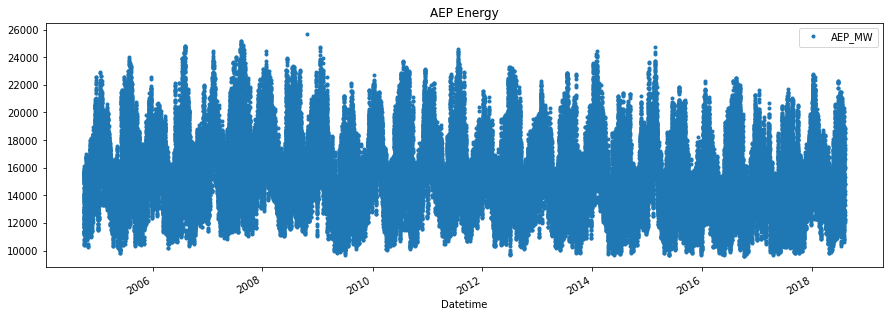

In [ ]:
df.plot(style = '.', color = colour[0], figsize = (15,5), title = "AEP Energy")

## Data splitting

Split the data into training and testing data, split data at 01-01-2016

In [ ]:
train = df.loc[df.index < '01-01-2016']
test = df.loc[df.index >= '01-01-2016']

plot the train and test data

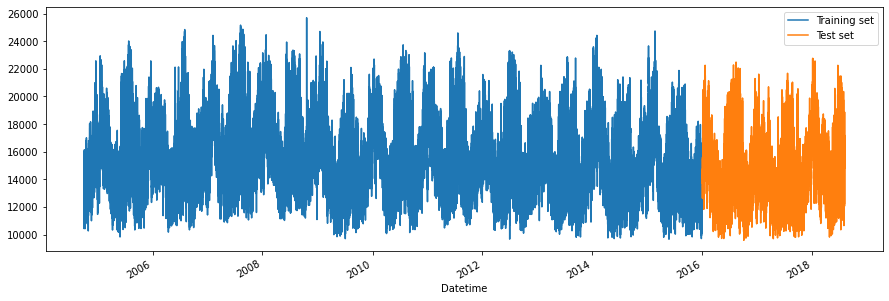

In [ ]:
fig , ax = plt.subplots(figsize = (15,5))
train.plot(ax=ax, label = "training set")
test.plot(ax = ax, label = "test data")
ax.legend(['Training set', 'Test set'])

Plot data for a random week AND day, to visualize weekly and daily variations in data

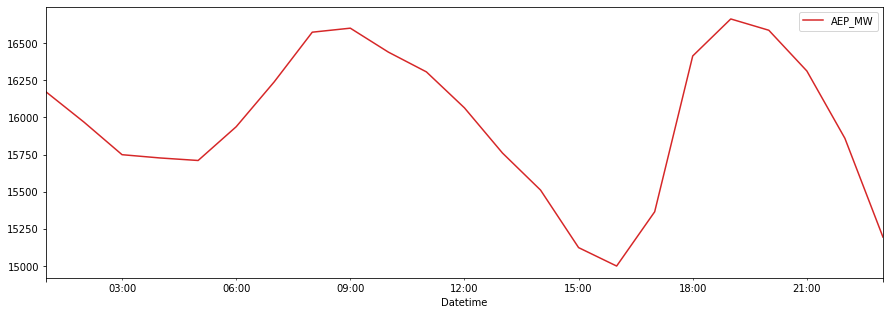

In [ ]:
df.loc[(df.index > '01-01-2015') & (df.index < '01-02-2015')].plot(style = '-' ,figsize = (15,5), color = colour[3])

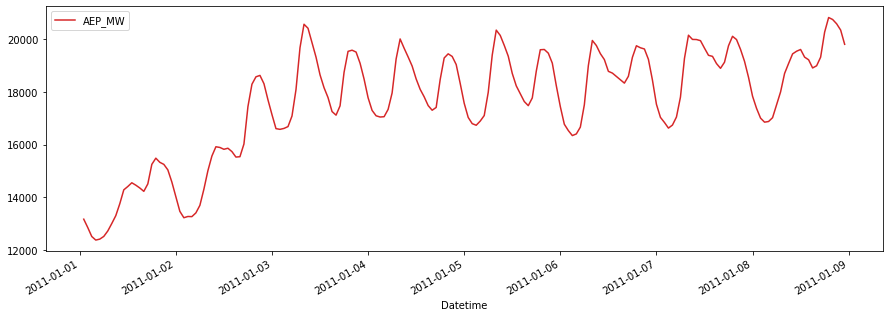

In [ ]:
df.loc[(df.index > '01-01-2011') & (df.index < '01-09-2011')].plot(style = '-' ,figsize = (15,5), color = colour[3])

## Feature Creation


Create different features for: hour, day, month, year, week and append it to the data-frame

In [ ]:
def create_features(df):

    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

Make boxplots to depict energy consumption hourly and monthly.(x variable would be hour and month and y variable would be the feature 'AEP_MW'

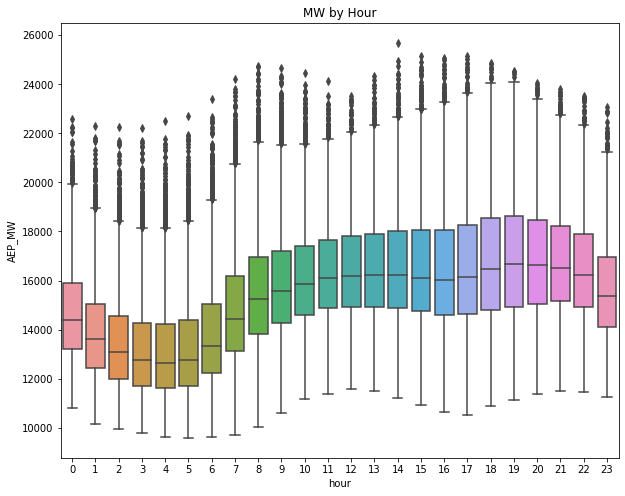

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='AEP_MW')
ax.set_title('MW by Hour')
plt.show()

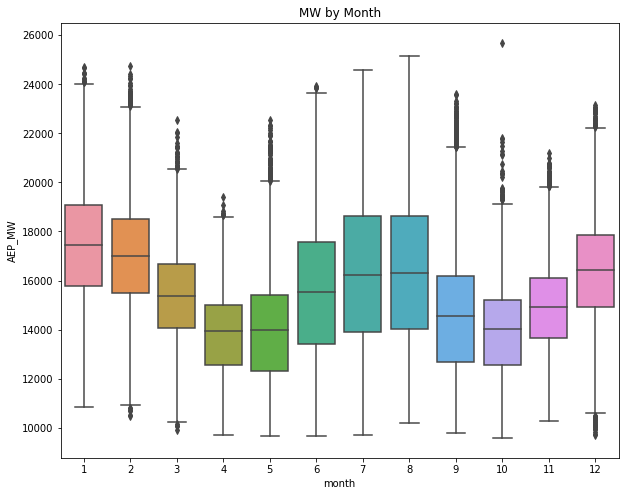

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='AEP_MW')
ax.set_title('MW by Month')
plt.show()

## Model Cretion

Run a regression XGBoost model on the training and testing data-set. Take 1000 estimators and learnning rate as 0.01 

In [ ]:
train = create_features(train)
test = create_features(test)


FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'AEP_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[13:25:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15720	validation_1-rmse:14831.8
[100]	validation_0-rmse:6010.65	validation_1-rmse:5184.93
[200]	validation_0-rmse:2708.6	validation_1-rmse:2237.91
[300]	validation_0-rmse:1765.04	validation_1-rmse:1741.3
[400]	validation_0-rmse:1525.16	validation_1-rmse:1730.96
[500]	validation_0-rmse:1442.44	validation_1-rmse:1746.14
[600]	validation_0-rmse:1401.82	validation_1-rmse:1752.09
[700]	validation_0-rmse:1371.26	validation_1-rmse:1752.95
[800]	validation_0-rmse:1347.8	validation_1-rmse:1746.29
[900]	validation_0-rmse:1330.9	validation_1-rmse:1743.05
[999]	validation_0-rmse:1317.28	validation_1-rmse:1741.12


XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, n_estimators=1000)

Predict values for the testing set using the model and plot them

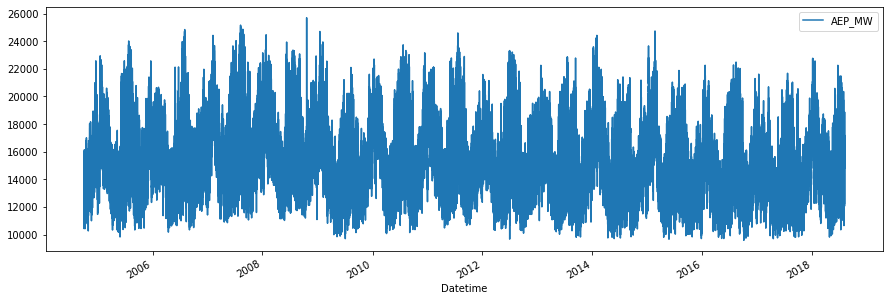

In [ ]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['AEP_MW']].plot(figsize=(15, 5))
# df['prediction'].plot(ax=ax, style='.')
# plt.legend(['Truth Data', 'Predictions'])
# ax.set_title('Raw Dat and Prediction')
# plt.show()

Use RMSE to find out the accuracy of your model

Find the importance of each feature use